In [1]:
import requests
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
# from random import shuffle

In [2]:
X_train, y_train = load_svmlight_file('a9a.svm', n_features=123)
X_test, y_test = load_svmlight_file('a9a.t.svm', n_features=123)

In [3]:
def loss_fn(w, x, y, reg):
    num_train = x.shape[0]
    num_classes = w.shape[1]
    scores = x.dot(w)
    correct_class_scores = scores[range(num_train), list(y)].reshape(-1, 1)
    margins = np.maximum(0, scores - correct_class_scores + 1)
    margins[range(num_train), list(y)] = 0
    loss = np.sum(margins) / num_train + 0.5 * reg * np.sum(w * w)
    coeff_mat = np.zeros((num_train, num_classes))
    coeff_mat[margins > 0] = 1
    coeff_mat[range(num_train), list(y)] = 0
    coeff_mat[range(num_train), list(y)] = - np.sum(coeff_mat, axis=1)
    
    dw = x.T.dot(coeff_mat)
    dw = dw / num_train + reg * w
    return loss, dw

In [4]:
class LinearClassifier:
    def __init__(self):
        self.w = None
        self.le = LabelEncoder()
        
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=1000, batch_size=200, verbose=False, method='gd'):
        num_train, dim = X.shape
        y = self.le.fit_transform(y)
        
        num_classes = int(np.max(y)) + 1
        
        v = np.zeros((dim, num_classes))
        G = np.zeros((dim, num_classes))
        gamma = 0.9
        beta = 0.9
        epsilon = 1e-5
        delta = np.zeros((dim, num_classes))
        m = np.zeros((dim, num_classes))
        
       
        if self.w is None:
#             print(dim, num_classes)
#             self.w = 0.001 * np.random.randn(dim, num_classes)
               self.w = np.zeros((dim, num_classes))
            
        loss_history = []
        for i in range(num_iters):
            batch_idx = np.random.choice(num_train, batch_size, replace=True)
            X_batch = X[batch_idx]
            y_batch = y[batch_idx]
            
            if method == 'gd':
                _, grad = self.loss(X_batch, y_batch, reg)
                loss, _ = self.loss(X, y, reg)

                self.w += -1 * learning_rate * grad
                
            elif method == 'NAG':
                _, grad = loss_fn(self.w - gamma * v ,X_batch, y_batch, reg)
                loss, _ = loss_fn(self.w - gamma * v ,X, y, reg)
                v = gamma * v + learning_rate * grad
                self.w -= v

            elif method == 'RMSProp':
                _, grad = self.loss(X_batch, y_batch, reg)
                loss, _ = self.loss(X, y, reg)
                G = gamma * G + (1 - gamma) * np.square(grad)
                self.w -= learning_rate * 1 * grad / np.sqrt(G + epsilon)

            elif method == 'AdaDelta':
                _, grad = self.loss(X_batch, y_batch, reg)
                loss, _ = self.loss(X, y, reg)
                G = gamma * G + (1 - gamma)* np.square(grad)
                dw = -np.sqrt(delta + epsilon) / np.sqrt(G + epsilon) * grad
                self.w += dw
                delta = gamma * delta + (1 - gamma) * np.square(delta)

            elif method == 'Adam':
                t = i + 1
                _, grad = self.loss(X_batch, y_batch, reg)
                loss, _ = self.loss(X, y, reg)
                m = beta * m + (1 - beta) * grad
                G = gamma * G + (1 - gamma) * np.square(grad)
                alpha = learning_rate * 1 * np.sqrt(1 - gamma ** t) / (1 - beta ** t)
                self.w -= alpha * m / np.sqrt(G + epsilon)
            
            loss_history.append(loss)
            if verbose and i % 100 == 0:
                print('iteration %d / %d: loss %f' % (i, num_iters, loss))
                
        return loss_history
        
    def predict(self, X):
        y_pred = np.zeros(X.shape[1])
        scores = X.dot(self.w)
        y_pred = np.argmax(scores, axis=1)
        y_pred = self.le.inverse_transform(y_pred)
        return y_pred

In [5]:
class LinearSVM(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return loss_fn(self.w, X_batch, y_batch, reg)

In [6]:
# X, y = load_svmlight_file(australian_svmlight_file_name)

In [7]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [8]:
clf = LinearSVM()
loss_history = clf.train(X_train, y_train, verbose=True, num_iters=2000, learning_rate=0.0001, method='Adam')

iteration 0 / 2000: loss 1.000000
iteration 100 / 2000: loss 0.861445
iteration 200 / 2000: loss 0.723120
iteration 300 / 2000: loss 0.584288
iteration 400 / 2000: loss 0.476407
iteration 500 / 2000: loss 0.465688
iteration 600 / 2000: loss 0.459981
iteration 700 / 2000: loss 0.454732
iteration 800 / 2000: loss 0.449622
iteration 900 / 2000: loss 0.444778
iteration 1000 / 2000: loss 0.440230
iteration 1100 / 2000: loss 0.435389
iteration 1200 / 2000: loss 0.430602
iteration 1300 / 2000: loss 0.425920
iteration 1400 / 2000: loss 0.421313
iteration 1500 / 2000: loss 0.416736
iteration 1600 / 2000: loss 0.412106
iteration 1700 / 2000: loss 0.407544
iteration 1800 / 2000: loss 0.402904
iteration 1900 / 2000: loss 0.398613


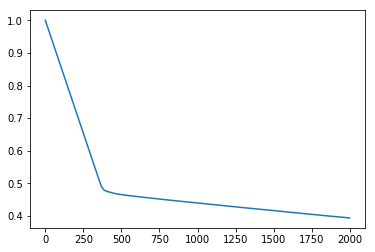

In [9]:
plt.plot(loss_history)
plt.show()

In [10]:
accuracy_score(y_test, clf.predict(X_test))

0.82998587310361771

In [11]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
lsvc.score(X_test, y_test)

0.84939500030710646

accuracy:  0.840980283766 ------ NAG
accuracy:  0.850132055771 ------ RMSProp
accuracy:  0.850377740925 ------ AdaDelta
accuracy:  0.850009213193 ------ Adam


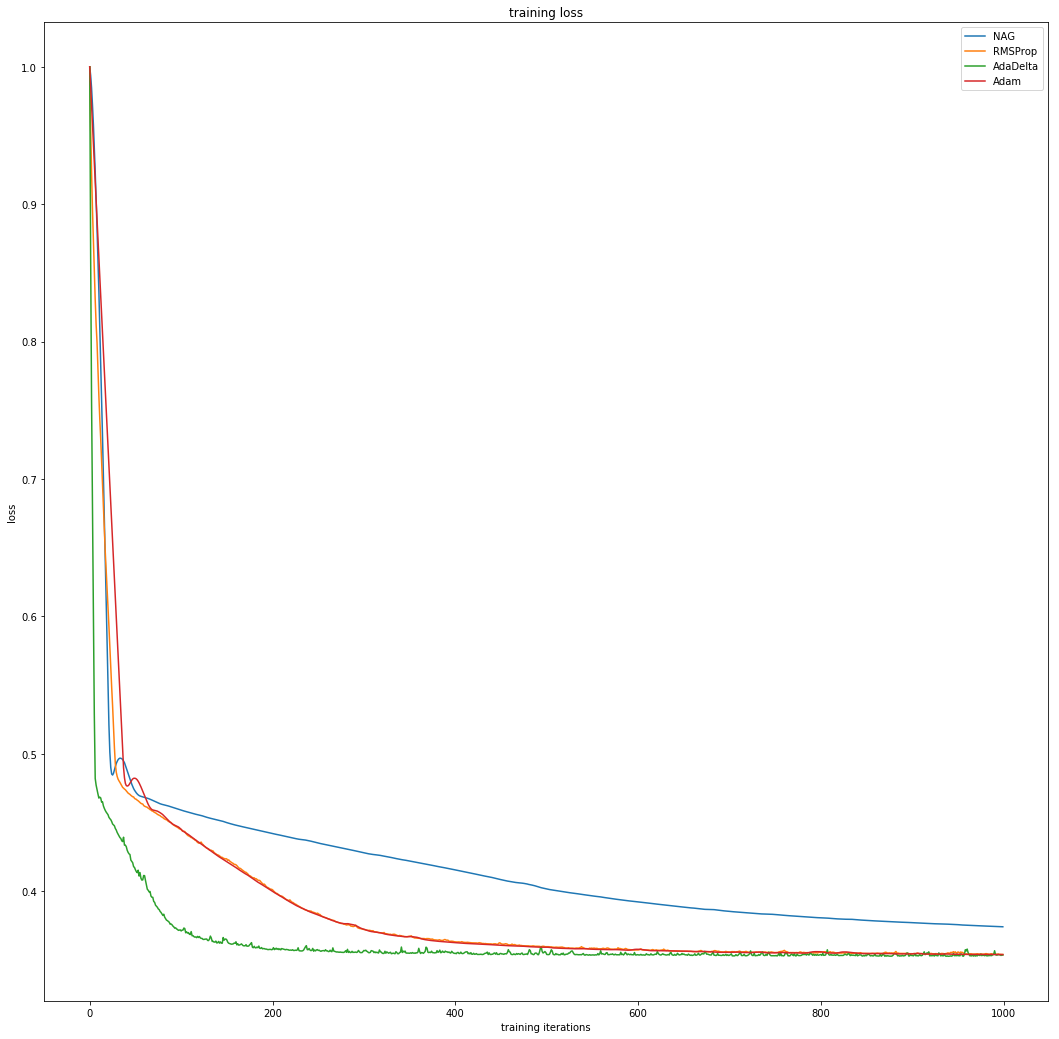

In [12]:
f = plt.figure('Loss', figsize=(18, 18))
ax = f.add_subplot(111)
ax.set_title('training loss')
ax.set_xlabel('training iterations')
ax.set_ylabel('loss')
algorithms = ['NAG', 'RMSProp', 'AdaDelta', 'Adam']
for algorithm in algorithms:
#     ax = f.add_subplot(2, 2, idx + 1)
#     ax.set_title('training loss of ' + algorithm)
#     ax.set_xlabel('training iterations')
#     ax.set_ylabel('loss')
    clf = LinearSVM()
    loss_history = clf.train(X_train, y_train, num_iters=1000, learning_rate=0.001, method=algorithm)
    pred = clf.predict(X_test)
    print('accuracy: ', accuracy_score(pred, y_test), '------', algorithm)
    ax.plot(loss_history, label=algorithm)

ax.legend()
plt.show()